In [1]:
import sys 
import networkx as nx
import pandas as pd
import numpy as np
import pickle as pic
import random
import scipy.stats as stats
import statistics

import cassiopeia.TreeSolver.simulation_tools.simulation_utils as sim_utils
import cassiopeia.TreeSolver.simulation_tools.dataset_generation as data_gen
import cassiopeia.TreeSolver.simulation_tools.birthdeath_utils as bd
from cassiopeia.TreeSolver.Node import Node
from cassiopeia.TreeSolver.Cassiopeia_Tree import Cassiopeia_Tree


from tqdm import tqdm_notebook
import matplotlib.pyplot as plt

import os

In [2]:
def degree_dist_leaves(network): #returns num of leaf descendants of each node
    root = [n for n in network if network.in_degree(n) == 0][0]
    dist = {}
    leaves_dist_helper(network, root, dist)
    return dist
    
def leaves_dist_helper(network, node, dist):
    if network.out_degree(node) == 0:
        dist[node] = 1
        return 1
    else:
        total_leaves = 0
        for i in network.successors(node):
            total_leaves += leaves_dist_helper(network, i, dist)
        dist[node] = total_leaves
        return(total_leaves)            
            
def record_heritable_dropouts(network):
    drops = {}
    dist = degree_dist_leaves(network)
    root = [n for n in network if network.in_degree(n) == 0][0]

    def record_h_helper(network, node, prev_drops, drops, total_time):
        curr_drops = network.nodes[node]['dropout']
        t = network.nodes[node]['parent_lifespan']
        to_add = list(set(curr_drops) - set(prev_drops))
        if len(to_add) > 0:
            for i in to_add:
                if i in drops:
                    drops[i].append((dist[node], t + total_time))
                else:
                    drops[i] = [(dist[node], t + total_time)]
        if network.out_degree(node) > 0:
            for j in network.successors(node):
                record_h_helper(network, j, curr_drops, drops, total_time + t)
    
    record_h_helper(network, root, [], drops, 0)
    return drops
            
def post_process_tree(network):
    root = [n for n in network if network.in_degree(n) == 0][0]
    if network.out_degree(root) > 0:
        for node in network.successors(root):
            post_process_helper(network, node, root)
    
def post_process_helper(network, node, parent):
    succs = []
    for i in network.successors(node):
        succs.append(i)
    if len(succs) == 1:
        t = network.nodes[node]['parent_lifespan']
        network.remove_node(node)
        for i in succs:
            network.add_edge(parent, i)
            network.nodes[i]['parent_lifespan'] += t
            post_process_helper(network, i, parent)
    else:
        for i in succs:
            post_process_helper(network, i, node)
            
def degree_dist(network): #returns dist of out degrees, and average out degree
    out_degrees = []
    for i in network.nodes:
        out_degrees.append(network.out_degree(i))
    fullness = out_degrees.count(1)/len(out_degrees)
    return out_degrees, sum(out_degrees)/len(out_degrees), fullness

def longest_path(network, node, ans):
    ans[0] += network.nodes[node]['parent_lifespan']
    for i in network.successors(node):
#         print(network.nodes[i]['parent_lifespan'])
        longest_path(network, i, ans)
        break

In [52]:
num_cells = 400
num_chars = 30
num_states = 1000

mut_perc = 0.53
sampling_prop = 0.5
epsilon = 25
stoch_dropout = 0.15
silence_rate = 0 

running_time = 100
ratio = 0.15
cassette_size = 3

In [53]:
path = "/data/yosef2/users/richardz/projects/benchmarking/" + str(num_cells) + "htest/"
print(path)
if os.path.exists(path) == False:
    os.mkdir(path)

mut_rate = np.log(1 - mut_perc)/(-1 * running_time)
samp_scale = 1/sampling_prop
vals = bd.get_net_div(100, round(num_cells * samp_scale), ratio)

for num in range(0, 50):

    prior_probabilities = bd.compute_priors(num_chars, num_states, mut_rate, 5, 0.5, skew_factor=0.0, num_skew=1)[0]

    tree, leaves = bd.construct_topology(num_chars, vals[0], vals[1], num_leaves = round(num_cells * samp_scale))
    network = tree.network
    bd.overlay_mutation_continuous(network, prior_probabilities, mut_rate, cassette_size, epsilon, silence_rate = silence_rate)

    sel_leaves = np.random.choice(leaves, round(sampling_prop * len(leaves)), replace = False)

    to_remove = list(set(leaves) - set(sel_leaves))
    for node in to_remove:
        bd.remove_and_prune(node, network)
    post_process_tree(network)

    #     pic.dump(tree, open(path + 'ground_truth_tree' + str(num) + '.pkl', 'wb'))
    pic.dump(prior_probabilities, open(path + 'priors' + str(num) + '.pkl', 'wb'))

    ground_cm = bd.get_character_matrix(sel_leaves)
    ground_cm.to_csv(path + 'ground_truth_cm' + str(num) + '.txt', sep = '\t')

    bd.overlay_heritable_dropout(network)
    drops = record_heritable_dropouts(network)
    pic.dump(drops, open(path + 'drops' + str(num) + '.pkl', 'wb'))
    bd.add_stochastic_leaves(sel_leaves, stoch_dropout, cassette_size)

    dropout_cm = bd.get_character_matrix(sel_leaves)
    dropout_cm = dropout_cm.astype(str)

    row_names = ['c' + str(i) for i in range(dropout_cm.shape[0])]
    dropout_cm.index = row_names
    dropout_cm.to_csv(path + '/dropout_cm' + str(num) + '.txt', sep = '\t')
    # dropout_cm.replace("*", "-").to_csv(path + '/dropout_cm_edit' + str(num) + '.txt', sep = '\t')
    pic.dump(tree, open(path + '/dropout_net' + str(num) + '.pkl', 'wb'))

/data/yosef2/users/richardz/projects/benchmarking/400htest/


In [870]:
recon_drops = pic.load(open("/data/yosef2/users/richardz/projects/benchmarking/400cells_base_m/avg_h/dropout_cm0_avg_h_hdrops.pkl", 'rb'))

# recon_drops_p = {}
# for i in range(30):
#     if i in recon_drops:
#         recon_drops_p[i] = (sum(recon_drops[i]))
#     else:
#         recon_drops_p[i] = 0

recon_drops_sorted = {}
for i in range(30):
    if i in recon_drops:
        recon_drops_sorted[i] = [(h[0], h[1]) for h in recon_drops[i] if sum(h) > 1]
    else:
        recon_drops_sorted[i] = [(0,0)]
        
recon_drops_num = {}
for i in np.arange(0, 30):
    if i in recon_drops:
        recon_drops_num[i] = len(recon_drops[i])
    else:
        recon_drops_num[i] = 0

recon_drops_sorted

{0: [(2, 0), (3, 0), (2, 0)],
 1: [(0, 0)],
 2: [(0, 0)],
 3: [(5, 1), (4, 0), (20, 0), (2, 0), (12, 1), (4, 0)],
 4: [(5, 1), (7, 0), (13, 0), (12, 1)],
 5: [(5, 1), (7, 0), (13, 0), (12, 1)],
 6: [(2, 0), (15, 0), (18, 0), (2, 0), (27, 0), (7, 0)],
 7: [(15, 0), (14, 0), (27, 0), (7, 0)],
 8: [(15, 0), (14, 0), (27, 0), (7, 0)],
 9: [(37, 0), (70, 0), (4, 0)],
 10: [(37, 0), (70, 0)],
 11: [(37, 0), (70, 0)],
 12: [(12, 0)],
 13: [(0, 0)],
 14: [(0, 0)],
 15: [(361, 0)],
 16: [(361, 0)],
 17: [(361, 0)],
 18: [(8, 0), (92, 4)],
 19: [(7, 0), (92, 4)],
 20: [(7, 0), (92, 4)],
 21: [(0, 2), (1, 1), (4, 0), (13, 0), (6, 1)],
 22: [(13, 0), (6, 1)],
 23: [(13, 0), (6, 1)],
 24: [(1, 1), (4, 0), (2, 1), (4, 0)],
 25: [(0, 0)],
 26: [(0, 0)],
 27: [(8, 0), (3, 1), (15, 2), (3, 0), (3, 0), (2, 2), (6, 0), (1, 1)],
 28: [(16, 2), (6, 0)],
 29: [(7, 0), (6, 0)]}

In [871]:
drops = pic.load(open("/data/yosef2/users/richardz/projects/benchmarking/400cells_base_m/drops0.pkl", 'rb'))

# drops_p = {}
# for i in range(30):
#     if i in drops:
#         drops_p[i] = (sum(drops[i]))
#     else:
#         drops_p[i] = 0
    
drops_sorted = {}
for i in range(30):
    if i in drops:
        drops_sorted[i] = [n for n in drops[i] if n > 1]
    else:
        drops_sorted[i] = [0]
        
drops_num = {}
for i in np.arange(0, 30):
    if i in drops:
        drops_num[i] = len(drops[i])
    else:
        drops_num[i] = 0

drops_sorted

{0: [3, 3, 3],
 1: [3, 3, 3],
 2: [3, 3, 3],
 3: [22, 8, 6, 19, 2, 4, 18],
 4: [22, 8, 6, 6, 19, 2, 4, 18],
 5: [22, 8, 6, 6, 19, 2, 4, 18],
 6: [3, 17, 2, 2, 2, 5, 3, 46, 4],
 7: [3, 17, 2, 2, 2, 5, 3, 46, 4],
 8: [3, 17, 2, 2, 5, 3, 46, 4],
 9: [145, 3, 5],
 10: [145, 3, 5],
 11: [145, 5],
 12: [15],
 13: [15],
 14: [15],
 15: [400],
 16: [400],
 17: [400],
 18: [11, 2, 15, 2, 5, 2, 2, 22, 7, 11, 4, 9, 7, 5, 4],
 19: [11, 2, 15, 2, 5, 2, 2, 22, 7, 11, 4, 9, 7, 5, 4],
 20: [11, 2, 15, 2, 5, 2, 2, 22, 7, 11, 4, 9, 7, 5, 4],
 21: [3, 16, 2, 2, 2],
 22: [3, 16, 2, 2, 2],
 23: [3, 16, 2, 2, 2],
 24: [3, 3, 2, 5, 2, 4, 2, 3, 4],
 25: [3, 3, 2, 5, 2, 4, 2, 3, 4],
 26: [3, 3, 2, 5, 2, 4, 2, 3, 4],
 27: [3, 8, 4, 4, 7, 3, 4, 2, 9, 7, 3, 2, 2],
 28: [3, 8, 4, 4, 7, 3, 4, 2, 9, 2, 7, 3, 2, 2],
 29: [3, 8, 4, 4, 7, 3, 4, 2, 9, 2, 7, 3, 2, 2]}

In [872]:
# drops_diff = {}
# for i in range(30):
#     recon_sum = 0
#     base_sum = 0
#     if i in recon_drops_p:
#         recon_sum = recon_drops_p[i]
#     if i in drops_p:
#         base_sum = drops_p[i]
#     drops_diff[i] = (recon_sum - base_sum)/(base_sum + 1)
# drops_diff

In [873]:
precisions = {}
for i in range(30):
    if sum(drops_sorted[i]) == 0:
        if sum([h[0] for h in recon_drops_sorted[i]]) != 0:
            precisions[i] = 'overcounted'
        else:
            precisions[i] = 0.0
    else:
        precisions[i] = sum([h[0] for h in recon_drops_sorted[i]])/sum(drops_sorted[i])

# for i in range(30):
#     if i % cassette_size == 0:
#         if precisions[i + 1] < precisions[i] and precisions[i + 2] < precisions[i]:
#             precisions.pop(i + 1)
#             precisions.pop(i + 2)

statistics.mean(precisions.values())

0.5724949907303992

In [874]:
recalls = {}
for i in range(30):
    if sum([h[0] for h in recon_drops_sorted[i]]) + sum([h[1] for h in recon_drops_sorted[i]]) != 0:
        recalls[i] = sum([h[0] for h in recon_drops_sorted[i]])/(sum([h[0] for h in recon_drops_sorted[i]]) + sum([h[1] for h in recon_drops_sorted[i]]))
statistics.mean(recalls.values())

0.9638663302094338

In [853]:
ks = {}
for i in range(30):
    ks[i] = stats.ks_2samp(drops_sorted[i], [sum(h) for h in recon_drops_sorted[i]])[1]
statistics.mean(ks.values())

0.46793612930877865

In [910]:
drops_comp = {}
for i in np.arange(30):
    drops_comp[i] = (drops_sorted[i], recon_drops_sorted[i])
drops_comp

{0: ([1, 2],
  [(0, 1), (0, 1), (0, 1), (0, 1), (0, 1), (2, 1), (0, 1), (0, 1), (0, 1)]),
 1: ([1, 2], [(0, 0)]),
 2: ([0], [(0, 0)]),
 3: ([1, 1, 1, 1, 22, 4, 12, 1, 4, 1, 2, 1, 65, 1, 1, 1, 3],
  [(1, 2), (2, 0), (105, 12)]),
 4: ([1, 1, 1, 1, 22, 3, 4, 12, 1, 4, 1, 2, 1, 65, 1, 1, 1, 3], [(108, 12)]),
 5: ([1, 1, 1, 1, 22, 3, 4, 12, 1, 4, 1, 2, 1, 65, 1, 1, 1, 3], [(108, 12)]),
 6: ([41, 2, 3, 2],
  [(0, 1),
   (0, 1),
   (13, 1),
   (0, 1),
   (0, 1),
   (3, 0),
   (1, 0),
   (2, 1),
   (22, 2),
   (0, 1),
   (0, 1)]),
 7: ([41, 2, 1, 3, 2, 1], [(13, 1), (23, 2)]),
 8: ([41, 1, 2, 1], [(13, 1), (21, 2)]),
 9: ([6, 1, 1, 2, 1, 3, 1, 1, 1, 1, 1, 2, 3, 1],
  [(0, 1),
   (1, 0),
   (1, 0),
   (0, 1),
   (1, 0),
   (0, 1),
   (1, 1),
   (3, 0),
   (0, 1),
   (0, 1),
   (0, 1),
   (0, 1),
   (1, 0),
   (4, 0),
   (0, 1),
   (0, 1)]),
 10: ([6, 1, 1, 2, 1, 3, 1, 1, 1, 1, 1, 2, 3, 1], [(0, 0)]),
 11: ([6, 1, 1, 2, 1, 3, 1, 1, 1, 1, 1, 2, 3, 1], [(0, 0)]),
 12: ([1, 1, 2],
  [(0, 1), (0, 1)

In [6]:
num_chars = 30
heritable_sizes = []
recon_sizes = []
avg_depth = []
silences = []
recall = []
precision = []
ks_p = []

for num in range(0, 100):
    recon_drops = pic.load(open("/data/yosef2/users/richardz/projects/benchmarking/400cells_base_m/avg_h/dropout_cm" + str(num) + "_avg_h_hdrops.pkl", 'rb'))
    drops = pic.load(open("/data/yosef2/users/richardz/projects/benchmarking/400cells_base_m/drops" + str(num) + ".pkl", 'rb'))
    rates = pic.load(open("/data/yosef2/users/richardz/projects/benchmarking/400cells_base_m/silence_rates" + str(num) + ".pkl", 'rb'))
    
    drops_sorted = {}
    for i in range(num_chars):
        if i in drops:
            heritable_sizes.extend(drops[i])
            drops_sorted[i] = drops[i]
        else:
            drops_sorted[i] = [0]

    recon_drops_sorted = {}
    for i in range(num_chars):
        if i in recon_drops:
            recon_sizes.extend([sum(n) for n in recon_drops[i]])
            recon_drops_sorted[i] = recon_drops[i]
        else:
            recon_drops_sorted[i] = [(0,0)]
            
    silences.extend([val for val in rates for _ in range(0, 3)])

#     avg_depths = {}
#     for i in range(num_chars):
#         avg_depths[i] = statistics.mean([h[1] for h in drops_sorted[i]])
#     avg_depth.extend(avg_depths.values())
    
    recalls = {}
    for i in range(num_chars):
        if sum([n for n in drops_sorted[i]]) == 0:
            if sum([h[0] for h in recon_drops_sorted[i]]) != 0:
                recalls[i] = 0.0
            else:
                recalls[i] = 1.0
        else:
            recalls[i] = sum([h[0] for h in recon_drops_sorted[i]])/sum([n for n in drops_sorted[i]])

    recall.extend(recalls.values())
    
    precisions = {}
    for i in range(30):
        if sum([h[0] for h in recon_drops_sorted[i]]) + sum([h[1] for h in recon_drops_sorted[i]]) != 0:
            precisions[i] = sum([h[0] for h in recon_drops_sorted[i]])/(sum([h[0] for h in recon_drops_sorted[i]]) + sum([h[1] for h in recon_drops_sorted[i]]))
    precision.extend(precisions.values())
    
    ks = {}
    for i in range(30):
        ks[i] = stats.ks_2samp([h for h in drops_sorted[i]], [sum(h) for h in recon_drops_sorted[i]])[1]
    ks_p.extend(ks.values())

StatisticsError: mean requires at least one data point

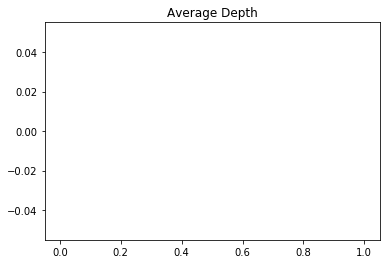

In [4]:
plt.hist(avg_depth)
plt.title("Average Depth")
plt.show
print(statistics.mean(avg_depth))

7 21.8587219343696


21449

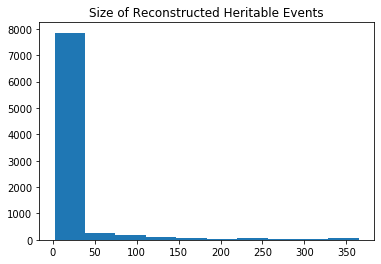

In [14]:
plt.hist([n for n in recon_sizes if n > 1])
plt.title("Size of Reconstructed Heritable Events")
plt.show
print(statistics.median([n for n in recon_sizes if n > 1]), statistics.mean([n for n in recon_sizes if n > 1]))
len([n for n in heritable_sizes if n > 1])

In [ ]:
plt.hist(precision)
plt.title("Precision")
plt.show
print(statistics.median(precision))

0.56


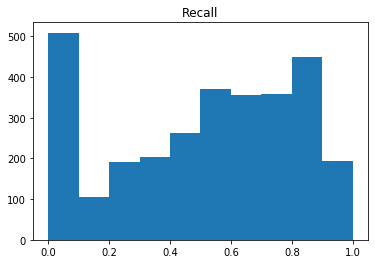

In [913]:
plt.hist(recall)
plt.title("Recall")
plt.show
print(statistics.median(recall))

0.2857142857142857


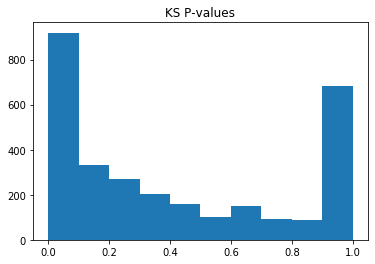

In [914]:
plt.hist(ks_p)
plt.title("KS P-values")
plt.show
print(statistics.median(ks_p))

In [915]:
from sklearn.linear_model import LinearRegression
model = LinearRegression()
model.fit(np.array(silences).reshape(-1, 1), np.array(recall))
r_sq = model.score(np.array(silences).reshape(-1, 1), np.array(recall))
r_sq

0.15449714705862638

0.42330288173778713


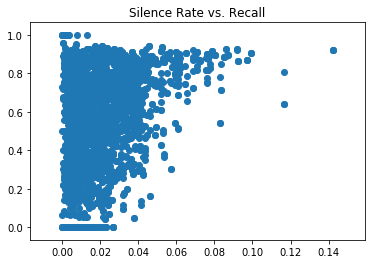

In [916]:
plt.scatter(np.array(silences).reshape(-1, 1), np.array(recall))
plt.title("Silence Rate vs. Recall")
plt.show
print(statistics.mean(ks_p))

In [454]:
path = "/data/yosef2/users/richardz/projects/benchmarking/" + str(num_cells) + "htest/"
# path = "/data/yosef2/users/mattjones/projects/metastasis/JQ19/5k/trees/"

drop_perc_i = []
stoch_perc_i = []
herit_perc_i = []
mut_perc_i = []
max_spc_i = []
avg_spc_i = []
size_i = []
num_chars_i = []

# for i in range(1, 101):
for i in range(0, 50):
    cm = pd.read_csv(path + 'dropout_cm' + str(i) + '.txt', sep = '\t', index_col = 0)
#     cm = pd.read_csv(path + 'lg' + str(i) + '/lg' + str(i) + '_character_matrix.txt', sep = '\t', index_col = 0)
    num_dropped = 0
    num_mut = 0
    num_dropped = (cm.values == '-').sum() + (cm.values == '*').sum()
    stoch_perc_i.append((cm.values == '-').sum()/num_dropped)
    herit_perc_i.append((cm.values == '*').sum()/num_dropped)
    num_mut = cm.shape[0] * cm.shape[1] - num_dropped - (cm.values == '0').sum()
    drop_perc_i.append(num_dropped/(cm.shape[0] * cm.shape[1]))
    mut_perc_i.append(num_mut/(cm.shape[0] * cm.shape[1] - num_dropped))
    
    spc = bd.states_per_char(cm)
    avg_spc_i.append(sum(spc)/len(spc))
    max_spc_i.append(max(spc))
    
    size_i.append(cm.shape[0])
    num_chars_i.append(cm.shape[1])

NameError: name 'num_cells' is not defined

In [455]:
plt.hist(stoch_perc_i)
plt.title("Percentage of Dropouts that are Stochastic for Trees of Size 400")
plt.show

NameError: name 'stoch_perc_i' is not defined

In [456]:
print(statistics.mean(herit_perc_i))
print(statistics.mean(drop_perc_i))

NameError: name 'herit_perc_i' is not defined

In [617]:
vals

NameError: name 'vals' is not defined

In [39]:
def reject_outliers(data, m=2):
    return [n for n in data if abs(n - np.mean(data)) < m * np.std(data)]

for s_drop in range(4,5):

    path = "/data/yosef2/users/richardz/projects/heritable_prop_exp/400cells_exp_" + str(s_drop) + "/"
    cm_list = []
    drop_perc = []

    counter = 0
    for num in range(0, 50):
        cm = pd.read_csv(path + "dropout_cm" + str(num) + ".txt", sep = '\t', index_col = 0)
        for i in range(cm.shape[1]):
            val = ((cm.iloc[:,i] == '-').sum() + (cm.iloc[:,i] == '*').sum())/cm.shape[0]
            if val <= 1:
                cm_list.append(val)
            else:
                counter += 1

        num_dropped = (cm.values == '-').sum() + (cm.values == '*').sum()
        drop_perc.append(num_dropped/(cm.shape[0] * cm.shape[1]))

    drop_perc = reject_outliers(drop_perc)

    path = "/data/yosef2/users/mattjones/projects/metastasis/JQ19/5k/trees/"

    cm_list_g = []
    drop_perc_g = []
    accepted = 0

    for i in range(1, 101):
        cm = pd.read_csv(path + 'lg' + str(i) + '/lg' + str(i) + '_character_matrix.txt', sep = '\t', index_col = 0)

        num_dropped = (cm.values == '-').sum() + (cm.values == '*').sum()
        if num_dropped/(cm.shape[0] * cm.shape[1]) > min(drop_perc) and num_dropped/(cm.shape[0] * cm.shape[1]) < max(drop_perc):
            accepted += 1
            for i in range(cm.shape[1]):
                cm_list_g.append((cm.iloc[:,i] == '-').sum()/cm.shape[0])
                drop_perc_g.append(num_dropped/(cm.shape[0] * cm.shape[1]))

    print(stats.ks_2samp(cm_list, cm_list_g, alternative = 'two-sided'))

# cm_list_f = []
# drop_perc_f = []
# accepted = 0

# for i in range(1, 101):
#     cm = pd.read_csv(path + 'lg' + str(i) + '/lg' + str(i) + '_character_matrix.txt', sep = '\t', index_col = 0)
    
#     num_dropped = (cm.values == '-').sum() + (cm.values == '*').sum()
#     if num_dropped/(cm.shape[0] * cm.shape[1]) > 0 and num_dropped/(cm.shape[0] * cm.shape[1]) < 1:
#         accepted += 1
#         for i in range(cm.shape[1]):
#             cm_list_f.append((cm.iloc[:,i] == '-').sum()/cm.shape[0])
#             drop_perc_f.append(num_dropped/(cm.shape[0] * cm.shape[1]))
    

Ks_2sampResult(statistic=0.07298089171974523, pvalue=0.00010770705257756585)


<function matplotlib.pyplot.show(*args, **kw)>

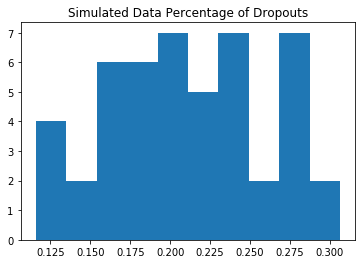

In [40]:
plt.hist(drop_perc)
plt.title("Simulated Data Percentage of Dropouts")
plt.show

<function matplotlib.pyplot.show(*args, **kw)>

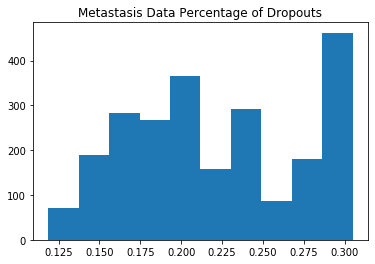

In [41]:
plt.hist(drop_perc_g)
plt.title("Metastasis Data Percentage of Dropouts")
plt.show

<function matplotlib.pyplot.show(*args, **kw)>

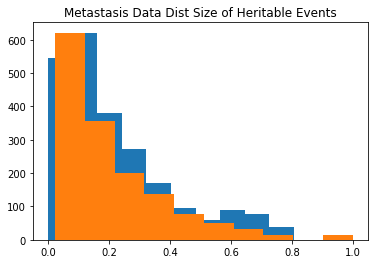

In [42]:
plt.hist(cm_list_g)
plt.title("Simulated Data Dist Size of Heritable Events")
plt.show
plt.hist(cm_list)
plt.title("Metastasis Data Dist Size of Heritable Events")
plt.show

In [43]:
stats.ks_2samp(cm_list, cm_list_g, alternative = 'two-sided')

Ks_2sampResult(statistic=0.07298089171974523, pvalue=0.00010770705257756585)

<function matplotlib.pyplot.show(*args, **kw)>

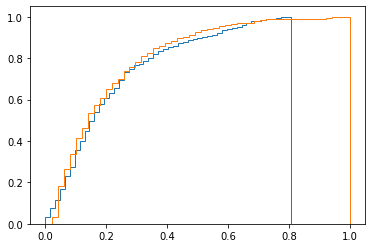

In [44]:
plt.hist(cm_list_g, 50, density=True, histtype='step', cumulative=True)
plt.hist(cm_list, 50, density=True, histtype='step', cumulative=True)
plt.show